In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import sqlite3
from iminuit import Minuit
from scipy.stats import chi2
from ExternalFunctions import nice_string_output, add_text_to_ax
#https://math.stackexchange.com/questions/1521128/given-a-line-and-a-point-in-3d-how-to-find-the-closest-point-on-the-line
matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('axes',  labelsize=20)
matplotlib.rc('font', **{'size'   : 18, 'family':'monospace'})
matplotlib.rcParams['figure.figsize'] = (12, 5)
matplotlib.rcParams['figure.titlesize'] = 22

all_dom_coordinates = pd.read_csv('/groups/icecube/debes/work/analyses/Efficiency/data/5083_DOM_coordinates_with_homemade_dom_id_from_burnsample.csv')
folder = '/groups/icecube/debes/work/analyses/Efficiency/data/burnsample_efficiency_reco/'

# Just the same as distance efficiency, but calculating the absorption length for each 10m layer. and plotting absorption length vs. z.
 

In [2]:
nbins = 50
RANGE = (-530,580)
variable = 'photon_z'
n_files = 20
use_horizontal_photons = True
hs = {'bins':nbins, 'range':RANGE}

rd_all_doms_counts , rd_activated_counts ,  qrd_activated_counts  = np.zeros((n_files,nbins)), np.zeros((n_files,nbins)), np.zeros((n_files,nbins))
mc_all_doms_counts , mc_activated_counts ,  qmc_activated_counts  = np.zeros((n_files,nbins)), np.zeros((n_files,nbins)), np.zeros((n_files,nbins))
mct_all_doms_counts, mct_activated_counts,  qmct_activated_counts = np.zeros((n_files,nbins)), np.zeros((n_files,nbins)), np.zeros((n_files,nbins))

usecols1 = ['photon_z', 'cherenkov_z', 'charge', 'dom_z','photon_distance','activated']
usecols2 = ['photon_z', 'cherenkov_z', 'charge', 'dom_z','photon_distance','activated', 'GB_weights']

for i in range(n_files):
    rd_path  = folder+'4k_rd_photon_efficiency_reco_'+str(i)+'.parquet'
    mc_path  = folder+'4k_mc_photon_efficiency_reco_'+str(i)+'.parquet'
    mct_path = folder+'4k_mc_truth_photon_efficiency_reco_'+str(i)+'.parquet'

    rd =  pd.read_parquet(rd_path, columns=usecols1) 
    mc =  pd.read_parquet(mc_path, columns=usecols2)
    mct = pd.read_parquet(mct_path, columns=usecols2)

    mc['GB_weights'] = mc['GB_weights'].apply(lambda x: min(x, 40))
    mct['GB_weights'] = mct['GB_weights'].apply(lambda x: min(x, 40))

    # Choose photons closer than 100m
    rd = rd[rd['photon_distance']<100]
    mc = mc[mc['photon_distance']<100]
    mct = mct[mct['photon_distance']<100]

    # Choose horizontal photons
    if use_horizontal_photons:
        rd  =  rd[np.abs(rd['dom_z'] - rd['cherenkov_z'])<10]
        mc  =  mc[np.abs(mc['dom_z'] - mc['cherenkov_z'])<10]
        mct = mct[np.abs(mct['dom_z']- mct['cherenkov_z'])<10]
    
    ###### Photon distance histograms ######
    qrdcount, _        = np.histogram(rd[rd['activated'] == 1][variable], **hs,   weights=rd[rd['activated'] == 1]['charge'])
    rdcount, bin_edges = np.histogram(rd[rd['activated'] == 1][variable], **hs)
    rdcount2, _        = np.histogram(rd[variable], **hs)
    
    qmccount, _        = np.histogram(mc[mc['activated'] == 1][variable], **hs, weights=mc[mc['activated'] == 1]['charge']  *  mc[mc['activated'] == 1]['GB_weights'])
    mccount, _         = np.histogram(mc[mc['activated'] == 1][variable], **hs, weights=mc[mc['activated'] == 1]['GB_weights'])
    mccount2, _        = np.histogram(mc[variable], **hs,  weights=mc['GB_weights'])
    
    qmctcount, _       = np.histogram(mct[mct['activated'] == 1][variable], **hs, weights=mct[mct['activated'] == 1]['charge'] * mct[mct['activated'] == 1]['GB_weights'])
    mctcount, _        = np.histogram(mct[mct['activated'] == 1][variable], **hs, weights=mct[mct['activated'] == 1]['GB_weights'])
    mctcount2, _       = np.histogram(mct[variable], **hs,  weights=mct['GB_weights'])
    
    rd_activated_counts[i] , qrd_activated_counts[i] , rd_all_doms_counts[i]  = rdcount , qrdcount , rdcount2
    mc_activated_counts[i] , qmc_activated_counts[i] , mc_all_doms_counts[i]  = mccount , qmccount , mccount2
    mct_activated_counts[i], qmct_activated_counts[i], mct_all_doms_counts[i] = mctcount, qmctcount, mctcount2
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
x_data = bin_centers

In [11]:
def divide0(x,y):
#    return np.divide(x.astype(np.float32),   y.astype(np.float32),  out=np.zeros_like(y).astype(np.float32), where=y!=0)
    return np.divide(x, y, out=np.zeros_like(y), where=y!=0)
def divide0err(x,y, sigma_x=None, sigma_y=None):
    value = np.divide(x, y, where=y!=0)
    if sigma_x is None:
        sigma_x = np.sqrt(x)
    if sigma_y is None:
        sigma_y = np.sqrt(y)
    error = value * np.sqrt((sigma_x/x)**2 + (sigma_y/y)**2)
    #np.divide(1, , out=np.zeros_like(x), where=x!=0)
    return value, error

In [4]:
rd_activated , qrd_activated , rd_all_doms  = np.sum(rd_activated_counts,  axis=0), np.sum(qrd_activated_counts,  axis=0), np.sum(rd_all_doms_counts, axis=0)
mc_activated , qmc_activated , mc_all_doms  = np.sum(mc_activated_counts,  axis=0), np.sum(qmc_activated_counts,  axis=0), np.sum(mc_all_doms_counts, axis=0)
mct_activated, qmct_activated, mct_all_doms = np.sum(mct_activated_counts, axis=0), np.sum(qmct_activated_counts, axis=0), np.sum(mct_all_doms_counts, axis=0)

rdeff , rdeff_err  = divide0err(rd_activated, rd_all_doms)
mceff , mceff_err  = divide0err(mc_activated, mc_all_doms)
mcteff, mcteff_err = divide0err(mct_activated, mct_all_doms)

qrdeff , qrdeff_err  = divide0err(qrd_activated, rd_all_doms)
qmceff , qmceff_err  = divide0err(qmc_activated, mc_all_doms)
qmcteff, qmcteff_err = divide0err(qmct_activated, mct_all_doms)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
x_data = bin_centers

# Without charge

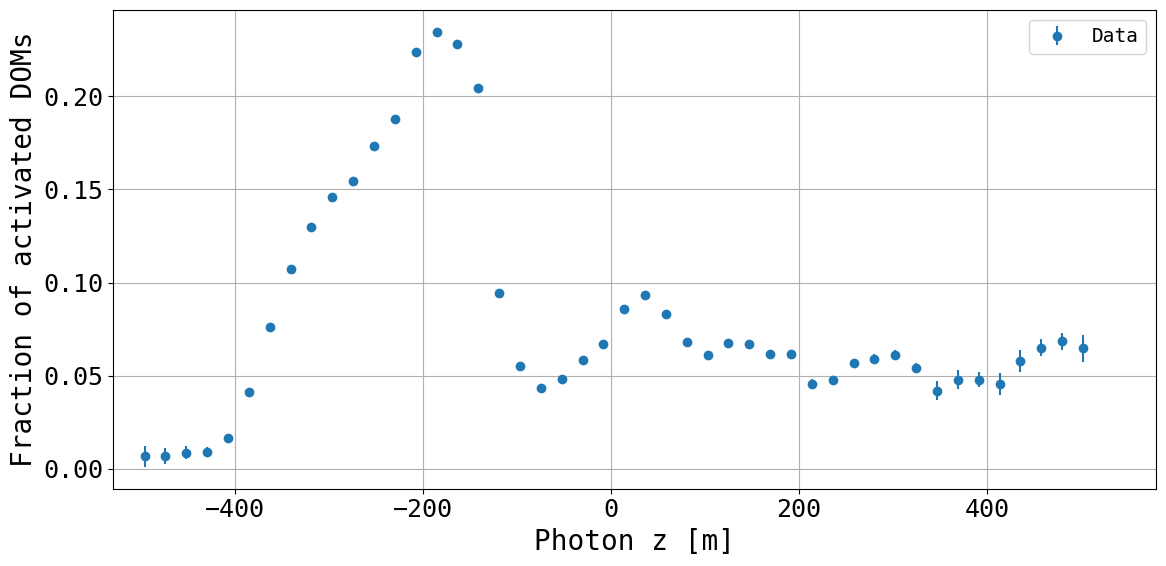

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
ax.errorbar(bin_centers[rd_activated>=nmin], rdeff[rd_activated>=nmin], yerr=rdeff_err[rd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax.set(xlabel = 'Photon z [m]', ylabel = 'Fraction of activated DOMs', xlim=RANGE)
ax.legend(fontsize=14)
ax.grid()
plt.tight_layout()
plt.savefig('plots/PQDPQz_without_charge_efficiency_horizontal_only_data.pdf')
plt.show()

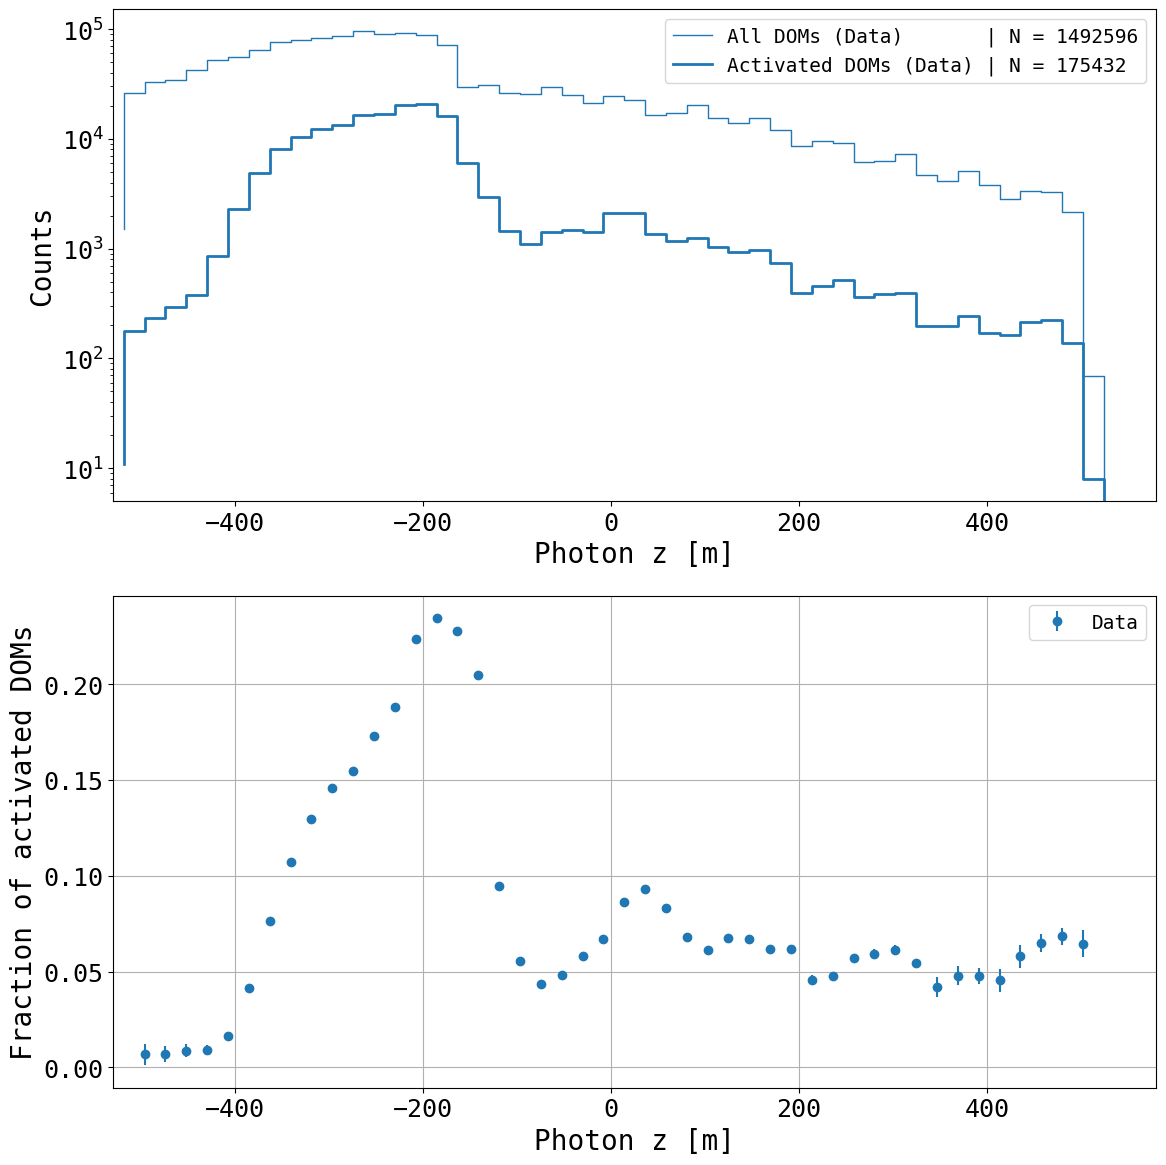

In [12]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
#ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
#ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))
ax[0].step(bin_centers, rd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(rd_activated)))
#ax[0].step(bin_centers, mc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mc_activated)))
#ax[0].step(bin_centers, mct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(mct_activated)))

ax[0].legend(loc = 'best', fontsize = 14)
ax[0].set(xlabel = 'Photon z [m]', ylabel = 'Counts', yscale='log', xlim=RANGE)
#ax[0].grid()
nmin = 50
ax[1].errorbar(bin_centers[rd_activated>=nmin], rdeff[rd_activated>=nmin], yerr=rdeff_err[rd_activated>=nmin],  color='C00',  fmt='o', label='Data')
#ax[1].errorbar(bin_centers[mc_activated>=nmin], mceff[mc_activated>=nmin], yerr=mceff_err[mc_activated>=nmin],  color='C01',  fmt='o', label='MC')
#ax[1].errorbar(bin_centers[mct_activated>=nmin], mcteff[mct_activated>=nmin], yerr=mcteff_err[mct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon z [m]', ylabel = 'Fraction of activated DOMs', xlim=RANGE)
ax[1].legend(fontsize=14)
ax[1].grid()
plt.tight_layout()
plt.savefig('plots/z__without_charge_efficiency_horizontal_only_data.pdf')
plt.show()

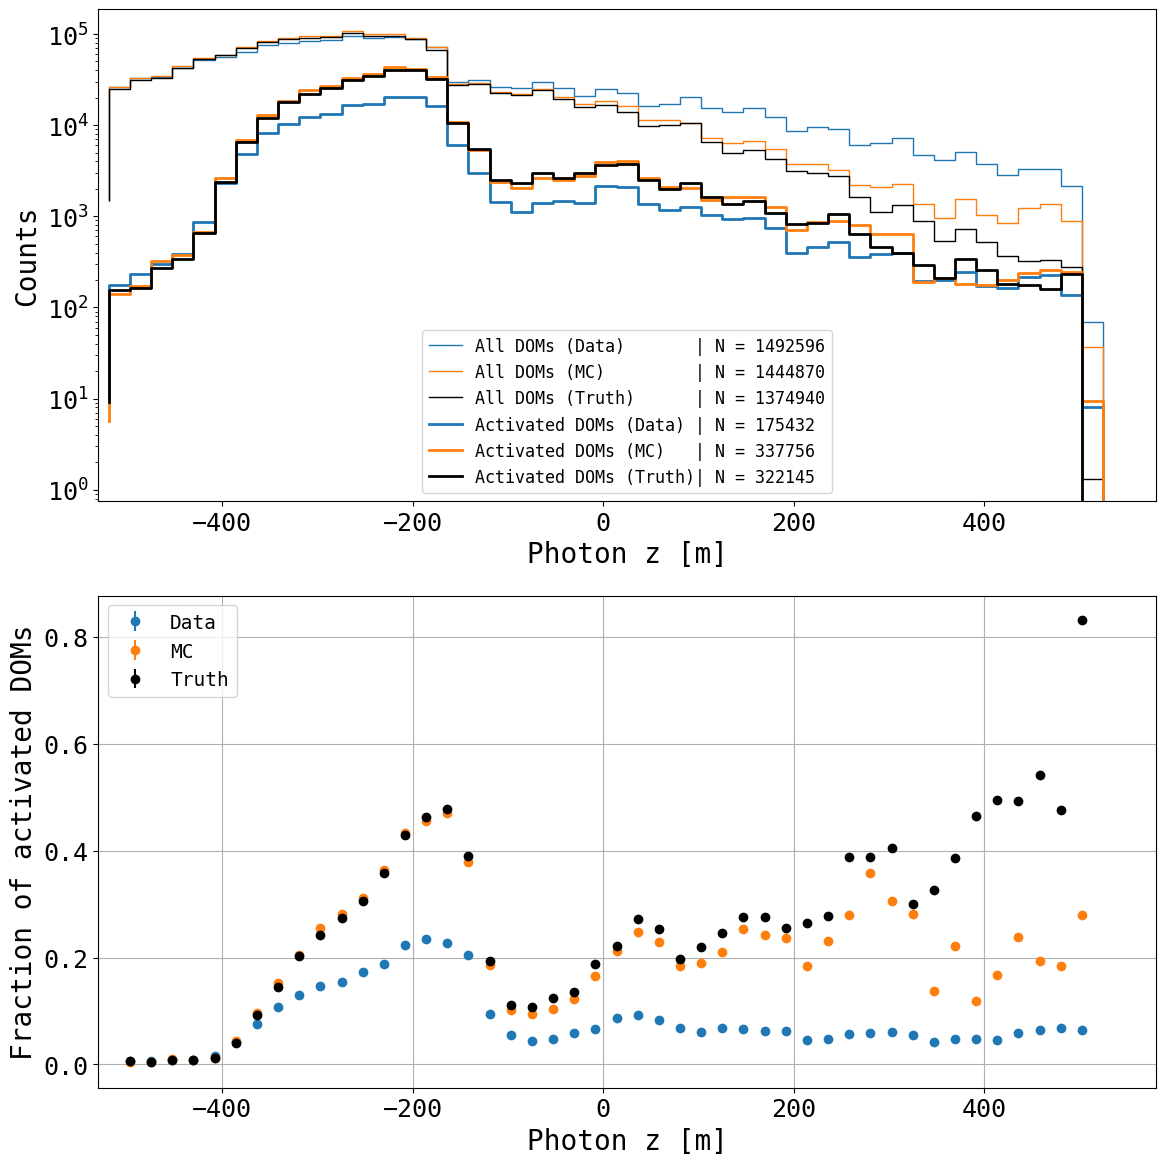

In [10]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))
ax[0].step(bin_centers, rd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(rd_activated)))
ax[0].step(bin_centers, mc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mc_activated)))
ax[0].step(bin_centers, mct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(mct_activated)))
ax[0].legend(loc = 'best', fontsize = 12)
ax[0].set(xlabel = 'Photon z [m]', ylabel = 'Counts', yscale='log', xlim=RANGE)

#ax[0].grid()
nmin = 50
ax[1].errorbar(bin_centers[rd_activated>=nmin], rdeff[rd_activated>=nmin], yerr=rdeff_err[rd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax[1].errorbar(bin_centers[mc_activated>=nmin], mceff[mc_activated>=nmin], yerr=mceff_err[mc_activated>=nmin],  color='C01',  fmt='o', label='MC')
ax[1].errorbar(bin_centers[mct_activated>=nmin], mcteff[mct_activated>=nmin], yerr=mcteff_err[mct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon z [m]', ylabel = 'Fraction of activated DOMs', xlim=RANGE)
ax[1].legend(fontsize=14)
ax[1].grid()
plt.tight_layout()
plt.savefig('plots/z_without_charge_efficiency_vs_truth_horizontal.pdf')
plt.show()

Man kan vælge at muonerne skal mindst nå ned til 300m eller noget.

# With Charge

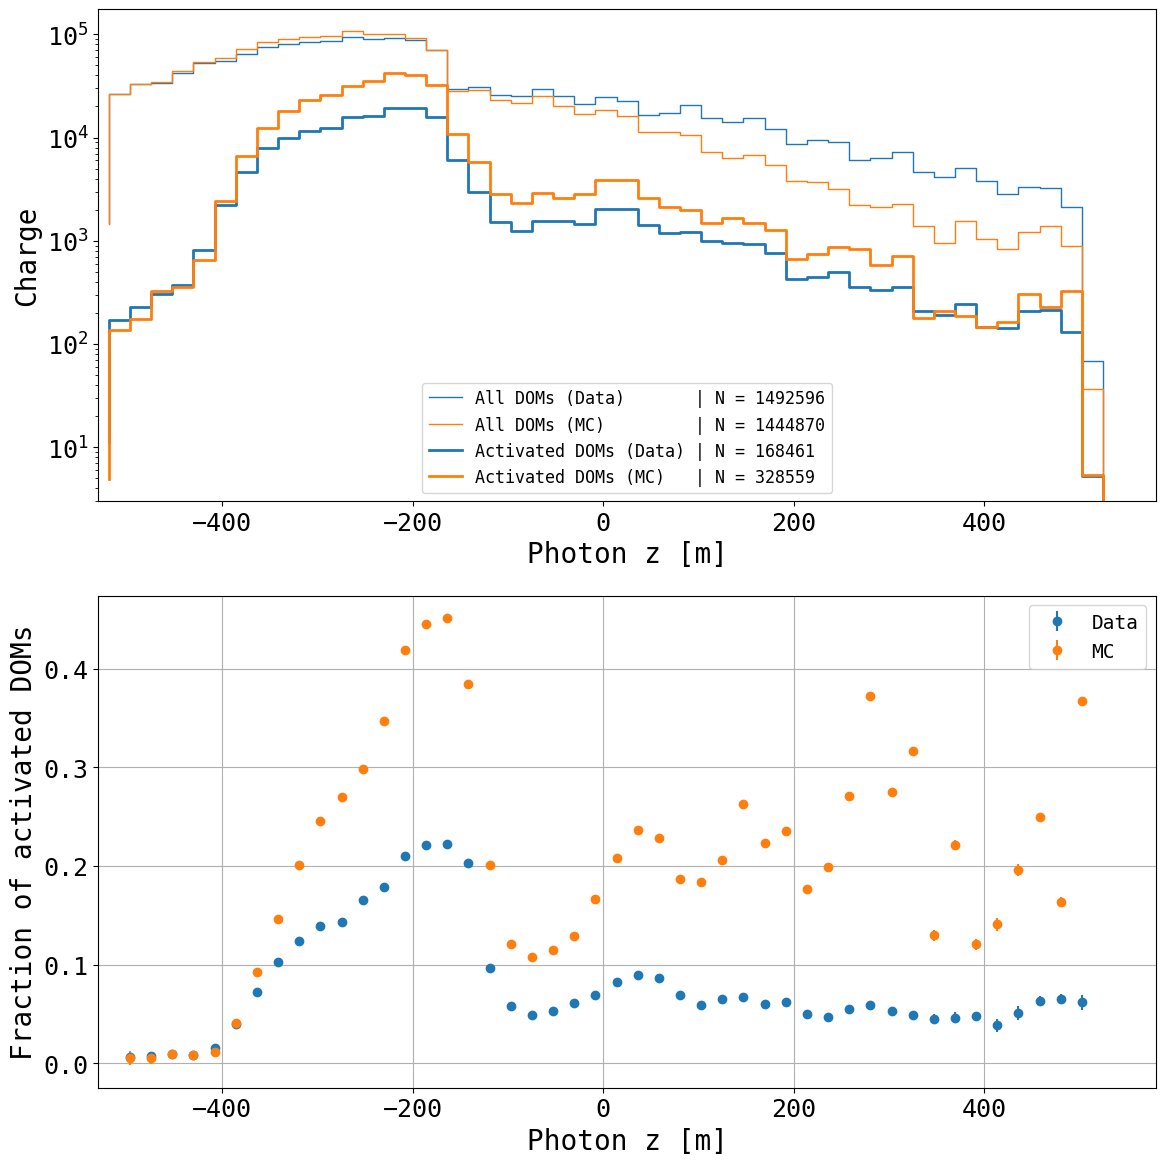

In [7]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
#ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))
ax[0].step(bin_centers, qrd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(qrd_activated)))
ax[0].step(bin_centers, qmc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(qmc_activated)))
#ax[0].step(bin_centers, qmct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(qmct_activated)))

ax[0].legend(loc = 'best', fontsize = 12)
ax[0].set(xlabel = 'Photon z [m]', ylabel = 'Charge', yscale='log', xlim=RANGE)
#ax[0].grid()
nmin = 50
ax[1].errorbar(bin_centers[qrd_activated>=nmin], qrdeff[qrd_activated>=nmin], yerr=qrdeff_err[qrd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax[1].errorbar(bin_centers[qmc_activated>=nmin], qmceff[qmc_activated>=nmin], yerr=qmceff_err[qmc_activated>=nmin],  color='C01',  fmt='o', label='MC')
#ax[1].errorbar(bin_centers[qmct_activated>=nmin], qmcteff[qmct_activated>=nmin], yerr=qmcteff_err[qmct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon z [m]', ylabel = 'Fraction of activated DOMs', xlim=RANGE)
ax[1].legend(fontsize=14)
ax[1].grid()
plt.tight_layout()
plt.savefig('plots/z_with_charge_efficiency_horizontal.pdf')
plt.show()

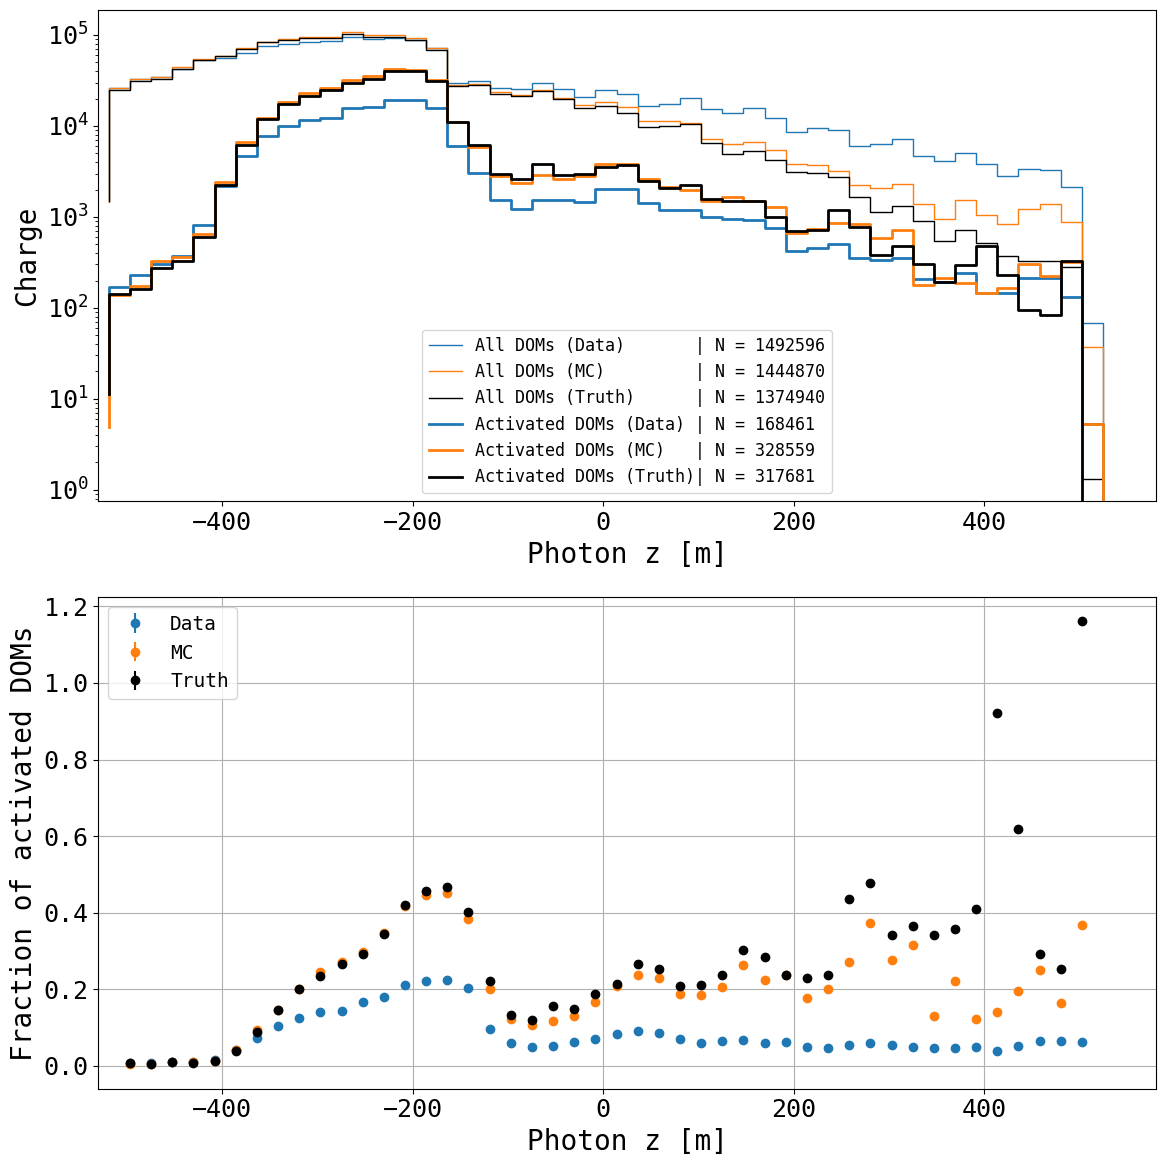

In [8]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))
ax[0].step(bin_centers, qrd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(qrd_activated)))
ax[0].step(bin_centers, qmc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(qmc_activated)))
ax[0].step(bin_centers, qmct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(qmct_activated)))

ax[0].legend(loc = 'best', fontsize = 12)
ax[0].set(xlabel = 'Photon z [m]', ylabel = 'Charge', yscale='log', xlim=RANGE)
#ax[0].grid()
nmin = 50
ax[1].errorbar(bin_centers[qrd_activated>=nmin], qrdeff[qrd_activated>=nmin], yerr=qrdeff_err[qrd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax[1].errorbar(bin_centers[qmc_activated>=nmin], qmceff[qmc_activated>=nmin], yerr=qmceff_err[qmc_activated>=nmin],  color='C01',  fmt='o', label='MC')
ax[1].errorbar(bin_centers[qmct_activated>=nmin], qmcteff[qmct_activated>=nmin], yerr=qmcteff_err[qmct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon z [m]', ylabel = 'Fraction of activated DOMs', xlim=RANGE)
ax[1].legend(fontsize=14)
ax[1].grid()
plt.tight_layout()
plt.savefig('plots/z_with_charge_efficiency_vs_truth_horizontal.pdf')
plt.show()